In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [2]:
import os
import sys
import cv2
import json
import torch
import zipfile
import numpy as np
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("../code/")

In [ ]:
from params import *

from training.main import validate
from training.predict import predict_entire_mask_no_thresholding, threshold_resize

from model_zoo.models import define_model

from data.dataset import InferenceDataset
from data.transforms import HE_preprocess

from utils.rle import enc2mask
from utils.torch import load_model_weights
from utils.metrics import dice_scores_img
from utils.plots import plot_thresh_scores

### Load

In [4]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")
df = pd.read_csv(OUT_PATH + "df_images.csv")

### Data

In [5]:
root = TIFF_PATH_4
rle_path = DATA_PATH + "train_4.csv"
reduce_factor = 1
rles = pd.read_csv(rle_path)

In [6]:
img = "2f6ecfcdf" # "aaa6a05cc"

In [7]:
dataset = InferenceDataset(
    f"{root}/{img}.tiff",
    rle=rles[rles['id'] == img]["encoding"],
    overlap_factor=2,
    reduce_factor=reduce_factor,
    transforms=HE_preprocess(augment=False, visualize=True),
)

In [15]:
len(dataset)

3162

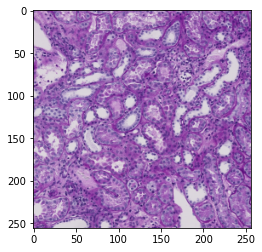

In [8]:
img = dataset[1000].numpy().transpose(1, 2, 0)

plt.imshow(img)

### Inference

In [53]:
def validate(model, config, val_images, log_folder=None, use_full_size=True, global_threshold=None):
    if use_full_size:
        root = TIFF_PATH
        rle_path = DATA_PATH + "train.csv"
        reduce_factor = REDUCE_FACTOR
        batch_size = config.val_bs // 4
    else:
        root = TIFF_PATH_4
        rle_path = DATA_PATH + "train_4.csv"
        reduce_factor = 1
        batch_size = config.val_bs // 4

    rles = pd.read_csv(rle_path)
    rles_full = pd.read_csv(DATA_PATH + "train.csv")

    print("\n    -> Validating \n")
    scores = []

    for img in val_images:
        
        predict_dataset = InferenceDataset(
            f"{root}/{img}.tiff",
            rle=rles[rles['id'] == img]["encoding"],
            overlap_factor=config.overlap_factor,
            reduce_factor=reduce_factor,
            transforms=HE_preprocess(augment=False, visualize=False),
        )

        global_pred = predict_entire_mask_no_thresholding(
            predict_dataset, model, batch_size=batch_size, upscale=use_full_size
        )

        threshold, score = plot_thresh_scores(
            mask=predict_dataset.mask, pred=global_pred, plot=False
        )
        
        print(f" - Scored {score :.4f} for image {img} with threshold {threshold:.2f}")
        
        shape = df_info[df_info.image_file == img + ".tiff"][['width_pixels', 'height_pixels']].values.astype(int)[0]
        mask_truth = enc2mask(rles_full[rles_full['id'] == img]["encoding"], shape)
        
        global_threshold = global_threshold if global_threshold is not None else threshold
        global_pred = threshold_resize(global_pred, shape, threshold=global_threshold)
        
        score = dice_scores_img(global_pred, mask_truth)
        scores.append(score)
        
        print(f" - Scored {score :.4f} for image {img} with threshold {global_threshold:.2f} after resizing\n")

    return scores

In [54]:
def k_fold_inf(config, df, log_folder=None, use_full_size=True, global_threshold=None):
    """
    Performs a patient grouped k-fold cross validation.
    The following things are saved to the log folder : val predictions, val indices, histories

    Args:
        config (Config): Parameters.
        df (pandas dataframe): Metadata.
        log_folder (None or str, optional): Folder to logs results to. Defaults to None.
    """
    folds = df[config.cv_column].unique()
    scores = []

    for i, fold in enumerate(folds):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {len(folds)}  -------------\n")
            df_val = df[df[config.cv_column] == fold].reset_index()
            
            val_images = df_val["tile_name"].apply(lambda x: x.split("_")[0]).unique()

            model = define_model(
                config.decoder,
                config.encoder,
                num_classes=config.num_classes,
                encoder_weights=config.encoder_weights,
            ).to(config.device)
            model.zero_grad()
            
            load_model_weights(model, log_folder + f"{config.decoder}_{config.encoder}_{i}.pt")
            
            scores += validate(
                model,
                config,
                val_images,
                log_folder=log_folder,
                use_full_size=use_full_size,
                global_threshold=global_threshold
            )
    return scores

In [55]:
# log_folder = "../logs/2020-12-21/3/"  # se_resnext50
# log_folder = "../logs/2020-12-22/9/"  # b4
log_folder = "../logs/2020-12-22/10/"  # b5 
log_folder = "../logs/2020-12-28/17/"  # b5  (BEST)
# log_folder = "../logs/2020-12-23/2/"  # b6

In [56]:
class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

config = json.load(open(log_folder + 'config.json', 'r'))
config = Config(**config)

In [65]:
global_threshold = 0.4

In [67]:
scores = k_fold_inf(
    config, 
    df, 
    log_folder=log_folder, 
    use_full_size=False, 
    global_threshold=global_threshold
)


-------------   Fold 1 / 4  -------------


 -> Loading weights from ../logs/2020-12-28/17/Unet_efficientnet-b5_0.pt


    -> Validating 

 - Scored 0.9229 for image 2f6ecfcdf with threshold 0.35
 - Scored 0.9220 for image 2f6ecfcdf with threshold 0.40 after resizing
 - Scored 0.8977 for image aaa6a05cc with threshold 0.40
 - Scored 0.8993 for image aaa6a05cc with threshold 0.40 after resizing

-------------   Fold 2 / 4  -------------


 -> Loading weights from ../logs/2020-12-28/17/Unet_efficientnet-b5_1.pt


    -> Validating 

 - Scored 0.9271 for image cb2d976f4 with threshold 0.50
 - Scored 0.9243 for image cb2d976f4 with threshold 0.40 after resizing
 - Scored 0.9364 for image 0486052bb with threshold 0.55
 - Scored 0.9352 for image 0486052bb with threshold 0.40 after resizing

-------------   Fold 3 / 4  -------------


 -> Loading weights from ../logs/2020-12-28/17/Unet_efficientnet-b5_2.pt


    -> Validating 

 - Scored 0.8846 for image e79de561c with threshold 0.35
 - Scor

In [68]:
print(f'Local CV score is {np.mean(scores):.4f} for threshold {global_threshold}')

Local CV score is 0.9014 for threshold 0.4


In [64]:
print(f'Local CV score is {np.mean(scores):.4f} for threshold {global_threshold}')

Local CV score is 0.9023 for threshold 0.5


In [61]:
print(f'Local CV score is {np.mean(scores):.4f} for threshold {global_threshold}')

Local CV score is 0.9028 for threshold 0.45
